## Homework 3: Ulrich GOUE and Gabriel ROMON

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from helper import GMM, log_gaussian_pdf, plot_countour
from scipy.stats import multivariate_normal

In [2]:
%matplotlib inline

## load data...

In [3]:
def load_data(kind='data'):
    filename = '.\classification_data_HWK3\EMGaussian.%s'%kind
    df = pd.read_csv(filename, sep=' ', names = ['X1', 'X2'])
    n = df.shape[0]

    X = df.values
    return X

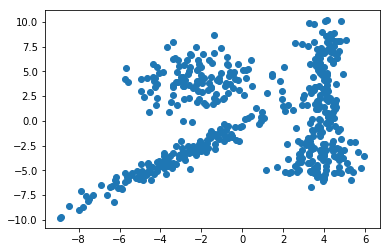

In [4]:
X = load_data()
X_test = load_data('test')
plt.scatter(X[:,0], X[:,1])

## We implement alpha and beta recursion

In [5]:
from scipy.special import logsumexp

In [6]:
def compute_alpha(X, mu, sigma, A, p_0):
    """
    mu: the means
    sigma: the covariance
    A: probability transition matrix
    p_0: initial law
    K: number of classes
    
    """
    K = len(mu)
    T = X.shape[0]
    log_alpha = np.zeros((T,K))
    log_alpha[0] = np.log(p_0)
    for i in range(1,T):
        for c in range(K):
            log_alpha[i,c] = log_gaussian_pdf(X[i,:], mu[c], sigma[c]) + logsumexp(np.log(A[:,c]) + log_alpha[i-1] )
    return log_alpha

In [7]:
def compute_beta(X, mu, sigma, A):
    T = X.shape[0]
    K = len(mu)
    log_beta = np.zeros((T,K))

    for i in range(T-1,0,-1):
        for c in range(K):
            log_pdf = np.array([log_gaussian_pdf(X[i,:], mu[c], sigma[c]) for c in range(K)])
            log_beta[i-1,c] = logsumexp(np.log(A[c]) + log_pdf +  log_beta[i] )
    return log_beta

## We implement EM-HMM

In [8]:
def _Expectation(X, mu, sigma, A, p_0):
    """
    updating the probability transition matrix
    q[t,c] = P(t-th observation is in class c)
    
    """
    T = X.shape[0]
    K = len(mu)
    q = np.zeros((T,K))
    
    log_alpha = compute_alpha(X, mu, sigma, A, p_0)
    log_beta = compute_beta(X, mu, sigma, A)
    
    for i in range(T):
        log_denom = logsumexp(log_alpha[i] + log_beta[i])
        q_i = np.exp([num - log_denom for num in log_alpha[i]+log_beta[i] ])
        q[i,:] = q_i
        np.testing.assert_allclose(np.sum(q_i), 1, err_msg='{}'.format(np.sum(q_i)))
    return q

In [9]:
def compute_trans(X, mu, sigma, A, p_0, crop=True):
    """
    compute transition matrix
    trans[t,c,c'] = probability(y_t=c, y_t+1 = c' given the sample)
    """
    T = X.shape[0]
    K = len(mu)
    
    log_alpha = compute_alpha(X, mu, sigma, A, p_0)
    log_beta = compute_beta(X, mu, sigma, A)
    
    trans = np.zeros((T, K, K))
    for i in range(T-1):
        log_denom = logsumexp(log_alpha[i] + log_beta[i])
        for c in range(K):
            for c_ in range(K):
                trans[i, c, c_] = np.exp(log_alpha[i,c] + log_beta[i+1,c_] + np.log(A[c,c_])+ 
                                         log_gaussian_pdf(X[i+1,:], mu[c_], sigma[c_])- log_denom)
            #
        #
        np.testing.assert_allclose(np.sum(trans[i]), 1, err_msg='{}'.format(np.sum(trans[i])))
    if crop:
        return trans[:(T-1)]
    else:
        return trans
        
            
            
    
    

In [10]:
def inference_algorithm_gaussian(K, X, p_0, mu, sigma, A):
    """
    implement the inference algorithm for gaussian emission
    mu: the means
    sigma: the covariance
    A: probability transition matrix
    p_0: initial law
    K: number of classes
    X: samples
    """
    T = X.shape[0]
    S = list(range(K))
    previous = np.zeros((K,T))
    probs = np.zeros((K,T))

    for c in range(K):
        probs[c,0] = np.log(p_0[c]) + log_gaussian_pdf(X[0], mu[c,:], sigma[c,:,:])

    
    for i in range(1,T):
        for c in S:
            log_targets = np.array([probs[c_,i-1] + np.log(A[c_,c]) + log_gaussian_pdf(X[i], mu[c,:], sigma[c,:,:]) for c_ in S])
            probs[c,i] = log_targets.max()
            previous[c,i] = log_targets.argmax()
        #
    #
    x = np.zeros(T)
    prob = probs[:,T-1]
    x[T-1] = prob.argmax()
    for i in range(T-1,0,-1):
        x[i-1] = int(previous[int(x[i]),i])
    return x

In [11]:
class EMHMM():
    
    """
    putting altogether
    
    """
    
    def __init__(self, X, K=4):
        self.X = X
        self.K = K
        self.N = X.shape[0]
        self.d = X.shape[1]
        self.A = (1/K)*np.ones((K,K))
        self.p_0 = p_0 = (1/K)*np.ones(K)
        
    def params_init(self):
        K = self.K
        d = self.d
        
        self.Q = np.zeros((self.N, K))
        
        clf = GMM(self.X, K)
        clf.fit(max_iter=75, verbose=False, isotropic=False)
        self.mu = clf.mu
        self.sigma = clf.sigma

    def likelihood_lower_bound(self, X):
        N = self.N 
        K = self.K 
        d = self.d
        trans = compute_trans(self.X, self.mu, self.sigma, self.A, self.p_0, crop=False)

        expec1, expec2, expec3 = 0., 0., 0.
        for i in range(N):
            x_i = X[i]

            for c in range(K):
                z_nk = self.Q[i, c]
                mu_k = self.mu[c, :]
                sigma_k = self.sigma[c, :, :]
                
                log_p_x_i = log_gaussian_pdf(x_i, mu_k, sigma_k)
                prob = z_nk * (log_p_x_i)
                
                expec1 += prob
                expec2 += z_nk * np.log(z_nk)
                expec3 += np.dot(trans[i,c], np.log(self.A[c]))

        loss = expec1 - expec2 + expec3 + np.dot(self.Q[0], np.log(self.p_0))
        return loss
    
    def likelihood_lower_bound_(self, X):
        N = self.N 
        K = self.K 
        d = self.d
        trans = compute_trans(self.X, self.mu, self.sigma, self.A, self.p_0, crop=False)
        Q = _Expectation(X, self.mu, self.sigma, self.A, self.p_0)

        expec1, expec2, expec3 = 0., 0., 0.
        for i in range(N):
            x_i = X[i]
            if i==0:
                expec4 = np.dot(Q[0], np.log(self.p_0))
            for c in range(K):
                z_nk = Q[i,c]
                mu_k = self.mu[c, :]
                sigma_k = self.sigma[c, :, :]
                
                log_p_x_i = log_gaussian_pdf(x_i, mu_k, sigma_k)
                prob = z_nk * (log_p_x_i) 
                
                expec1 += prob
                expec2 += z_nk * np.log(z_nk)
                expec3 += np.dot(trans[i,c], np.log(self.A[c]))

        loss = expec1 - expec2 + expec3 + expec4
        return loss
    
    def _E_step(self, X):
        
        self.Q = _Expectation(X, self.mu, self.sigma, self.A, self.p_0)

    def _M_step(self, X):
        trans = compute_trans(self.X, self.mu, self.sigma, self.A, self.p_0, crop=True)
        self.A = trans.sum(0)/ trans.sum(0).sum(1)[:, np.newaxis]
        K, d, N = self.K, self.d, self.N
        mu =  self.mu
 
        denoms = np.sum(self.Q, axis=0)
        

        # update cluster means
        nums_mu = [np.dot(self.Q[:, c], X) for c in range(K)] 
        for ix, (num, den) in enumerate(zip(nums_mu, denoms)):
            self.mu[ix, :] = num / den
        
        # update cluster covariances
        X, mu = self.X, self.mu
        for c in range(K):
            mu_c = self.mu[c, :]
            n_c = denoms[c]

            outer = np.zeros((d, d))
            lambda_ = 0.
            for i in range(N):
                wic = self.Q[i, c]
                xi = self.X[i, :]
                outer += wic * np.outer(xi - mu_c, xi - mu_c)

            outer /= n_c
            self.sigma[c, :, :] = outer

        self.p_0 = self.A[0]
        
    def fit(self, max_iter=75, rtol=1e-3, verbose=False):
        self.params_init()
        prev_vlb = -np.inf
        self.count = 0
        
        for _iter in range(max_iter):
            self.count += 1
            try:
                self._E_step(self.X)             
                self._M_step(self.X)               
                vlb = self.likelihood_lower_bound(self.X)

                if verbose:
                    print('{}. Lower bound: {}'.format(_iter + 1, vlb))

                if np.abs((vlb - prev_vlb) / prev_vlb) <= rtol or np.isnan(vlb):
                    break

                prev_vlb = vlb
            
            except np.linalg.LinAlgError:
                print("Singular matrix: components collapsed")
                pass
            
    def predict(self):
        return inference_algorithm_gaussian(self.K, self.X, self.p_0, self.mu, self.sigma, self.A)
    
    def plot_clusters(self, title, save=None):
        K = self.K

        xmin, xmax = (self.X[:,0].min()-1.5, self.X[:,0].max()+2)
        ymin, ymax = (self.X[:,1].min()-1.5, self.X[:,1].max()+1.5)

        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7.5, 9)

        for c in range(K):
            rv = multivariate_normal(self.mu[c], self.sigma[c])

            x = np.linspace(xmin, xmax, 500)
            y = np.linspace(ymin, ymax, 500)

            X1, Y1 = np.meshgrid(x, y)
            xy = np.column_stack([X1.flat, Y1.flat])

            # density values at the grid points
            Z = rv.pdf(xy).reshape(X1.shape)
            ax = plot_countour(X, X1, Y1, Z, ax=ax, xlim=(xmin, xmax), ylim=(ymin, ymax))
            ax.plot(self.mu[c, 0], self.mu[c, 1], 'ro')
            
        # plot data points
        labels = self.Q.argmax(1)
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=30) 
        plt.title(title)
        plt.show()
        if save is not None:
            fig.savefig(save)

In [12]:
gmm = GMM(X, K=4)
gmm.fit(max_iter=75, verbose=False, isotropic=False)

C:\Users\utilisateur\Desktop\LAST_YEAR\PGM\HWK3\helper.py:259: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((vlb - prev_vlb) / prev_vlb) <= rtol or np.isnan(vlb):


In [13]:
hmm = EMHMM(X, 4)
hmm.fit(max_iter=10, rtol=1e-3, verbose=False)

C:\Users\utilisateur\Desktop\LAST_YEAR\PGM\HWK3\helper.py:259: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((vlb - prev_vlb) / prev_vlb) <= rtol or np.isnan(vlb):
C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


EM-HMM clustering


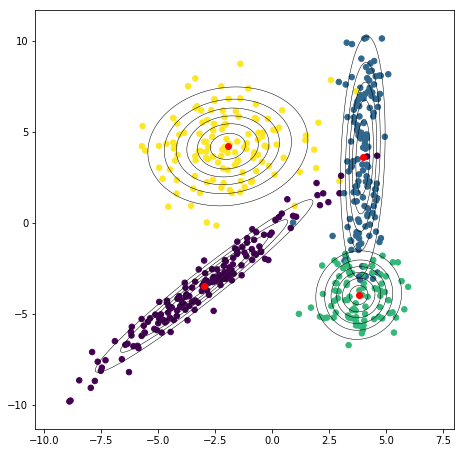

In [14]:
print('EM-HMM clustering')
hmm.plot_clusters('', save='EM-HMM.png')

EM-GMM Clustering


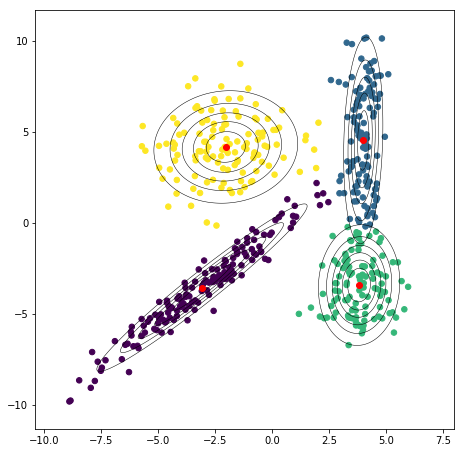

In [15]:
print('EM-GMM Clustering')
gmm.plot_clusters('', save='EM-GMM.png')

## Performances Summary

In [16]:
test_gmm = gmm.likelihood_lower_bound_(X_test)/X_test.shape[0]
test_hmm = hmm.likelihood_lower_bound_(X_test)/X_test.shape[0]
train_gmm = gmm.likelihood_lower_bound_(X)/X.shape[0]
train_hmm = hmm.likelihood_lower_bound_(X)/X.shape[0]

print('test GMM', test_gmm)
print('test HMM', test_hmm)
print('train GMM', train_gmm)
print('train HMM', train_hmm)

test GMM -4.835691061725009
test HMM -3.9239187337739256
train GMM -4.661061223099701
train HMM -3.825066740134953


In [17]:
report = pd.DataFrame({'train':[train_gmm, train_hmm], 'test':[test_gmm, test_hmm]})

In [18]:
report.index = ['GMM','HMM']
report.to_latex('report.tex')
report

,train,test
GMM,-4.661061,-4.835691
HMM,-3.825067,-3.923919


In [19]:
# Just to check if the differences of likelihood were an iteration number bias
for i in range(hmm.count):
    gmm._E_step(X)             
    gmm._M_step(X)
    
test_gmm = gmm.likelihood_lower_bound_(X_test)/X_test.shape[0]
train_gmm = gmm.likelihood_lower_bound_(X)/X.shape[0]

print('test GMM', test_gmm)
print('train GMM', train_gmm)

test GMM -4.822000289009826
train GMM -4.6563061938117665


In [20]:
dA = pd.DataFrame(hmm.A, columns=['yellow','blue','purple','green'])

In [21]:
dA.index = ['yellow','blue','purple','green']
dA

,yellow,blue,purple,green
yellow,0.906553,0.072861,0.020584,0.000002
blue,0.032437,0.022553,0.011531,0.933479
purple,0.034126,0.046542,0.877638,0.041694
green,0.063033,0.873919,0.047294,0.015754


In [22]:
dA.to_latex('kernel.tex')